# Problem Set 5

##### Serena Flint

Given Code:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML  # requires ffmpeg
# you may need to install ffmpeg as like this on a command line: > conda install ffmpeg

%matplotlib notebook  
%config InlineBackend.figure_format = 'retina'

In [98]:
# Laplacian operator
# dx is grid spacing, a is a 2D array
# roll shifts array by 1 index, in x or y directions 
# return Laplacian as an array

a_test = []
for i in range(100):
    a_test.append(np.arange(100.0*i, 100.0*(i+1)))
    
a_test = np.array(a_test)

def laplacian2D(a, dx):
    a_test = a
    return (- 4*a + np.roll(a,1,axis=0) + np.roll(a,-1,axis=0)\
            + np.roll(a,+1,axis=1) + np.roll(a,-1,axis=1)) / (dx**2)
# it is faster to use a whole array routine than to loop over all indices (in the notebook) 
# returned is an array.  You need to write a new routine like this one.

# Reaction parts of differential equations for 
# three different types of different Reaction diffusion equations 
# u,v are 2D arrays, alpha, beta could be numbers or arrays
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh-Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br2'): #modified Brusselator model (Problem 4)
        Ru,Rv = R_Br2(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS2'): #modified Gray_Scott model (Problem 4)
        Ru,Rv = R_GS2(u,v,alpha,beta)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 100, 0.5, 20, dt=0.0002
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 , dt = 0.005 
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v 
    Rv =  beta*u - (u**2)*v
    return Ru,Rv
        
#print(a_test)

def a_func():
    a_new = np.sin(np.tan(a_test**1.04)/8.0)
    return a_new

def b_func():
    b_new = np.cos(a_test**1.2)+(np.sin((a_test**2.0)))/(((a_test**2.0)+1.0)/6.0)
    return b_new


def R_Br2(u,v,alpha,beta): 
    Ru = alpha*a_func() - (beta*a_func()+1)*u + (u**2)*v 
    Rv =  beta*a_func()*u - (u**2)*v
    return Ru,Rv

# The Gray Scott Reaction Diffusion model
# alpha is feed rate for u, beta is kill or drain rate
# alpha kills v
# example: Du = 0.1; Dv=Du/2, alpha, beta = 0.037, 0.06, dt =1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =   u*(v**2) - (alpha + beta)*v
    return Ru, Rv

def R_GS2(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*a_func()*(1-u) 
    Rv =   u*(v**2) - (alpha*a_func() + beta*a_func())*v
    return Ru, Rv

In [99]:
# a class for initializing and computing and showing solutions to 
# a 2D reaction diffusion equation
# in this version I show both u,v images when plotted using animation
# I also allow you to return arrays so if the animation doesn't work
# you can display images directly
class Update_RD(object):
    
    # do this when creating a class object, axis info is passed, 
    # along with parameters for the reaction diffusion equation
    def __init__(self, fig, ax, alpha=5.0,beta=9,Du=2,Dv=22,\
                 n=100,dt=0.01,dx=1,rdtype='Br',nsteps=1):
        self.success = 0
        self.alpha = alpha  # parameter for reaction
        self.beta = beta    # parameter for reaction
        self.Du = Du  # diffusion coefficient for u
        self.Dv = Dv  # diffusion coefficient for v
        self.n = n    # dimension of 2D u,v arrays 
        self.rdtype = rdtype  # type of reaction diffusion model, is a string
        # the possible good string values are 'Br', 'GS', 'FN'
        
        self.dx = dx   # horizontal grid spacing
        self.dt = dt   # timestep
        self.nsteps = nsteps  # how many timesteps to take per display
        
        self.initialize_uv()  #initialize arrays, fill with initial conditions
        
        # axis info
        self.line0, = ax[0].plot([], [], 'k-')
        self.line1, = ax[1].plot([], [], 'k-')
        self.fig = fig  # passing this just in case we want to fuss with display
        self.ax = ax
        self.ax[0].set_aspect('equal')  # so we get square plots
        self.ax[1].set_aspect('equal')
        
        # show the u,v images initial conditions in constructor
        im0=self.ax[0].imshow(self.u,cmap='jet')
        im1=self.ax[1].imshow(self.v,cmap='hsv')
        #self.fig.colorbar(im0, ax=ax[0],fraction=0.046, pad=0.04)
        #self.fig.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)
        # I wish I could get the colorbar to work!
            
        fac_u= self.Du*self.dt/self.dx**2  # relevant for checking cfl condition
        fac_v= self.Dv*self.dt/self.dx**2  
        if (fac_u>1):
            print('cfl warning Du', fac_u)
        if (fac_v>1):
            print('cfl warning Dv', fac_v)
       
    #### end constructor
    
    # initial conditions for u,v arrays
    def initialize_uv(self):
        # I find that the Gray-Scott model needs these types of initial conditions
        if (self.rdtype=='GS'):
            self.u = np.zeros((self.n,self.n)) + 1.0  # u is 1
            self.v = np.zeros((self.n,self.n))        # v is 0
            for k in range(0,int(self.n/10)):
                i = int(self.n*np.random.rand())  # randomly chose some locations to set
                j = int(self.n*np.random.rand())
                self.v[i,j]=np.random.rand()  # set to number in [0,1)
        else: # whereas Brusellator and FN models seem to work with random, 
            #  near zero initial conditions
            self.u = 0.05*np.random.rand(self.n, self.n)  # initial u data uniform distribution
            self.v = 0.05*np.random.rand(self.n, self.n)  # initial v data
     
    # take a single dt timestep, update u,v arrays in place
    def update(self):       
        du = self.Du*laplacian2D(self.u, self.dx)    # compute diffusive terms
        dv = self.Dv*laplacian2D(self.v, self.dx)
        # compute reation terms
        Ru,Rv = Reaction(self.u,self.v,self.alpha,self.beta,self.rdtype)        
        # update u,v arrays, Eulerian method
        self.u = self.u + (du + Ru)*self.dt
        self.v = self.v + (dv + Rv)*self.dt
        
    # take nsteps, update u,v arrays in place
    def update_nsteps(self):
        for i in range(self.nsteps):
            self.update(); # take a single step
       
    # initialization for animation
    def init(self):
        lines = []
        self.success = 0
        self.line0.set_data([], [])
        self.line1.set_data([], [])
        return self.line0,self.line1,

    # called each display step! using animation, 
    # computation is only done when display is called
    def __call__(self, i):
        if i == 0:
            return self.init()

        self.success += 1  #otherwise
       
        # do nsteps times timestep for each display update
        self.update_nsteps()
            
        im0=self.ax[0].imshow(self.u,cmap='jet')
        im1=self.ax[1].imshow(self.v,cmap='hsv')
        #self.fig.colorbar(im0, ax=ax[0])
        # it would be nice to have colorbars, but they screw up in the animation
        return self.line0, self.line1,
    
    # return u,v arrays, whatever their current values happen to be 
    # (for testing and used if animations don't work)
    def return_uv(self):
        return self.u, self.v


 
### Problem 4

What happens if $\alpha$ and $\beta$ are function of position in the grid?  Modify/rewrite the routines to integrate the reaction diffusion equation with slowly varying $\alpha$, $\beta$ across the grid.  I found that abrupt changes in $\alpha$ or $\beta$ gave linear features, but a periodic or sinusoidal variation in $\alpha$ and $\beta$ made an image with very nice patterns slowly varying across it.  Some examples 
are shown below.

### Problem 1

It appears that below $\Delta t \approx 0.0085$ produces the most consistent results. Anything under $\Delta t \approx 0.009$ appears mostly consistent, but we can observe a slight wiggling motion. However, anything $\Delta \leq 0.01$ in general appears to stabilize at some point, but anything above this value overloads the Python simulation and will not even animate or produce a series of images. 

Below shows how inconsistent $\Delta t$ is around $0.01$ where the first set of animations show $\Delta t = 0.0099999$ and the second set of plots show $\Delta t = 0.0099996$.

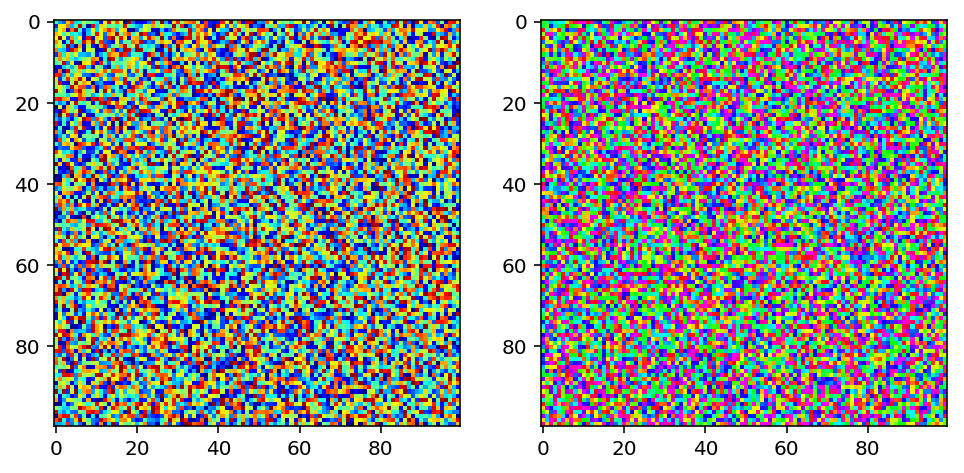

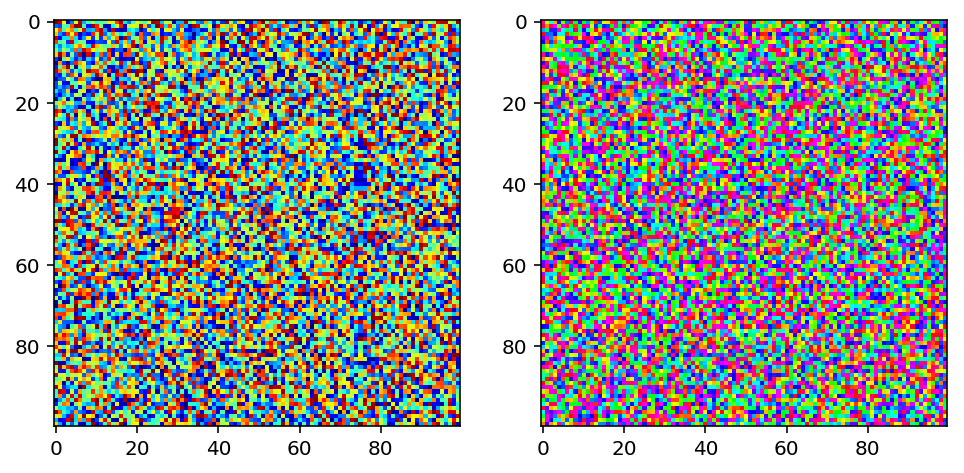

In [84]:
# set up the Brusselator model with some nice parameters giving 
# pattern formation
fig, ax = plt.subplots(1,2,figsize=(8,5))  # set up a figure with two panels
fig2, ax2 = plt.subplots(1,2,figsize=(8,5))

ud = Update_RD(fig,ax, alpha=5.0,beta=9.0,Du=2,Dv=22,\
                 n=100,dt=0.0099999,dx=1,rdtype='Br',nsteps=200)

ud2 = Update_RD(fig2,ax2, alpha=5.0,beta=9.0,Du=2,Dv=22,\
                 n=100,dt=0.0099996,dx=1,rdtype='Br',nsteps=200)
# create the object, assign parameters
# here n is the grid length, dt is the timestep, dx is the horizontal grid spacing
# alpha,beta, Du, Dv are the parameters for the reaction diffusion model

# nsteps=200 is the number of steps between display outputs
            
anim = animation.FuncAnimation(fig, ud, frames=np.arange(50), init_func=ud.init,
                     interval=100, blit=True)
anim2 = animation.FuncAnimation(fig2, ud2, frames=np.arange(50), init_func=ud.init,
                     interval=100, blit=True)
# here 50 is the number of images shown in the animation
# this last step sets up the animation, connecting output of the integration
# to the animation.  

In [73]:
# dt = 0.0099999
HTML(anim.to_html5_video())
# image on the left is u, that on the right is v

In [85]:
# dt = 0.0099996
HTML(anim2.to_html5_video())
# image on the left is u, that on the right is v

### Problem 2

It appears that there are ratios, lets call them a and b, where $a=\frac{D_{u}}{\Delta x^{2}}$ and $b=\frac{D_{u}}{\Delta x^{2}}$. If we change $\Delta x$ to 1.5, we know that $a = 0.\bar{4}$ and $b = 0.\bar{2}$.

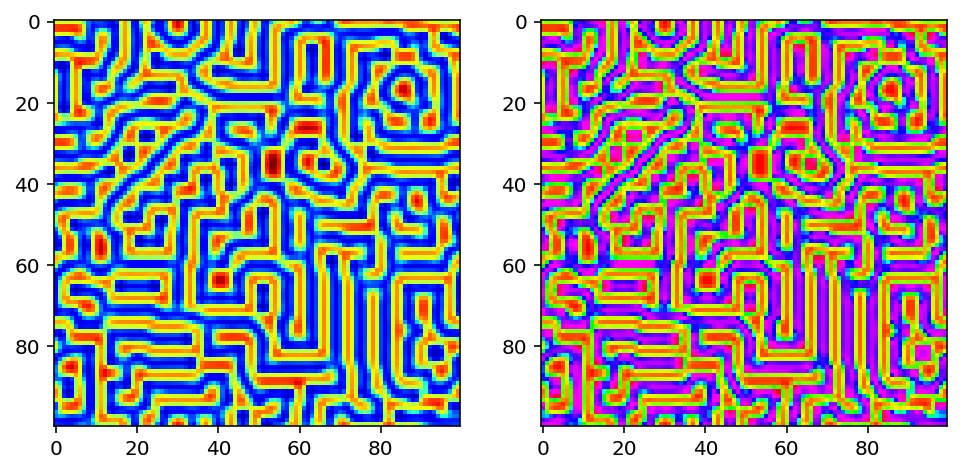

In [97]:
# changing dx to 1.5
fig, ax = plt.subplots(1,2,figsize=(8,5))
ud_GS = Update_RD(fig,ax, alpha=0.037,beta=0.06,Du=0.1,Dv=0.05,\
                 n=100,dt=1,dx=1.5,rdtype='GS',nsteps=200)
            
anim_GS = animation.FuncAnimation(fig, ud_GS, frames=np.arange(50), init_func=ud.init,
                     interval=100, blit=True)

# compute and show the animation
HTML(anim_GS.to_html5_video())

To adjust $D_{u}$ and $D_{v}$ so that the ratios stay equal to what we determined them before, we just need to set  $D_{u} = 0.\bar{4}$ and $D_{v} = 0.\bar{2}$ since $\Delta x = 1$ here. As we can see, this produces very similar results to the previous set of graphs with star-like patterns spreading radially outwards.

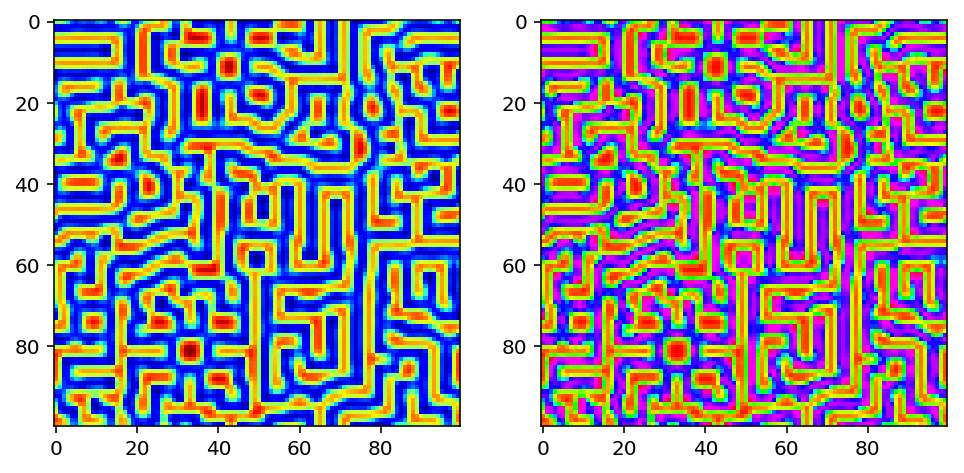

In [108]:
#changing Du and Dv to 0.0444444 and 0.0222222, respsectively
fig2, ax2 = plt.subplots(1,2,figsize=(8,5))
ud_GS2 = Update_RD(fig2,ax2, alpha=0.037,beta=0.06,Du=0.0444444,Dv=0.0222222,\
                 n=100,dt=1,dx=1.0,rdtype='GS',nsteps=200)
            
anim_GS2 = animation.FuncAnimation(fig2, ud_GS2, frames=np.arange(50), init_func=ud.init,
                     interval=100, blit=True)

HTML(anim_GS2.to_html5_video())

### Problem 3

For this problem, I wrote the new $\Delta^{2}$ function in the code below as newLaplacian2D(a, dx), and copied the Update_RD class and renamed it to Update_RD2. All instances to laplacian2D(a, dx) in this new class were changed to newLaplacian2D(a, dx).

Like with the previous Brusselator models for Problem 1, I used the provided code to generate animations utilizing the original Update_RD class, and then directly under it generated animations utilizing Update_RD2 to be able to more easily compare the two. For both animations I used $\Delta t = 0.08$.

We can see that these models are very similar at 0.08, but not exact. Through testing I noticed that the new Laplacian behaved significantly more different at higher $\Delta t$ values and also appeared more stable.

In [104]:
#new Laplacian2D method
def newLaplacian2D(a, dx):
    return  ( 0.2*(np.roll(a, +1, axis=0) + np.roll(a, -1, axis=0)\
                 + np.roll(a, +1, axis=1) + np.roll(a, -1, axis=1))\
                 - a + 0.05*(np.roll(a, [+1,+1], axis=(0,1))\
                            +np.roll(a, [-1,-1], axis=(0,1))\
                            +np.roll(a, [-1,+1], axis=(0,1))\
                            +np.roll(a, [+1,-1], axis=(0,1))\
                            ) ) * (4.0/dx**2)

class Update_RD2(object):
    
    # do this when creating a class object, axis info is passed, 
    # along with parameters for the reaction diffusion equation
    def __init__(self, fig, ax, alpha=5.0,beta=9,Du=2,Dv=22,\
                 n=100,dt=0.01,dx=1,rdtype='Br',nsteps=1):
        self.success = 0
        self.alpha = alpha  # parameter for reaction
        self.beta = beta    # parameter for reaction
        self.Du = Du  # diffusion coefficient for u
        self.Dv = Dv  # diffusion coefficient for v
        self.n = n    # dimension of 2D u,v arrays 
        self.rdtype = rdtype  # type of reaction diffusion model, is a string
        # the possible good string values are 'Br', 'GS', 'FN'
        
        self.dx = dx   # horizontal grid spacing
        self.dt = dt   # timestep
        self.nsteps = nsteps  # how many timesteps to take per display
        
        self.initialize_uv()  #initialize arrays, fill with initial conditions
        
        # axis info
        self.line0, = ax[0].plot([], [], 'k-')
        self.line1, = ax[1].plot([], [], 'k-')
        self.fig = fig  # passing this just in case we want to fuss with display
        self.ax = ax
        self.ax[0].set_aspect('equal')  # so we get square plots
        self.ax[1].set_aspect('equal')
        
        # show the u,v images initial conditions in constructor
        im0=self.ax[0].imshow(self.u,cmap='jet')
        im1=self.ax[1].imshow(self.v,cmap='hsv')
        #self.fig.colorbar(im0, ax=ax[0],fraction=0.046, pad=0.04)
        #self.fig.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)
        # I wish I could get the colorbar to work!
            
        fac_u= self.Du*self.dt/self.dx**2  # relevant for checking cfl condition
        fac_v= self.Dv*self.dt/self.dx**2  
        if (fac_u>1):
            print('cfl warning Du', fac_u)
        if (fac_v>1):
            print('cfl warning Dv', fac_v)
       
    #### end constructor
    
    # initial conditions for u,v arrays
    def initialize_uv(self):
        # I find that the Gray-Scott model needs these types of initial conditions
        if (self.rdtype=='GS'):
            self.u = np.zeros((self.n,self.n)) + 1.0  # u is 1
            self.v = np.zeros((self.n,self.n))        # v is 0
            for k in range(0,int(self.n/10)):
                i = int(self.n*np.random.rand())  # randomly chose some locations to set
                j = int(self.n*np.random.rand())
                self.v[i,j]=np.random.rand()  # set to number in [0,1)
        else: # whereas Brusellator and FN models seem to work with random, 
            #  near zero initial conditions
            self.u = 0.05*np.random.rand(self.n, self.n)  # initial u data uniform distribution
            self.v = 0.05*np.random.rand(self.n, self.n)  # initial v data
     
    # take a single dt timestep, update u,v arrays in place
    def update(self):       
        du = self.Du*newLaplacian2D(self.u, self.dx)    # compute diffusive terms
        dv = self.Dv*newLaplacian2D(self.v, self.dx)
        # compute reation terms
        Ru,Rv = Reaction(self.u,self.v,self.alpha,self.beta,self.rdtype)        
        # update u,v arrays, Eulerian method
        self.u = self.u + (du + Ru)*self.dt
        self.v = self.v + (dv + Rv)*self.dt
        
    # take nsteps, update u,v arrays in place
    def update_nsteps(self):
        for i in range(self.nsteps):
            self.update(); # take a single step
       
    # initialization for animation
    def init(self):
        lines = []
        self.success = 0
        self.line0.set_data([], [])
        self.line1.set_data([], [])
        return self.line0,self.line1,

    # called each display step! using animation, 
    # computation is only done when display is called
    def __call__(self, i):
        if i == 0:
            return self.init()

        self.success += 1  #otherwise
       
        # do nsteps times timestep for each display update
        self.update_nsteps()
            
        im0=self.ax[0].imshow(self.u,cmap='jet')
        im1=self.ax[1].imshow(self.v,cmap='hsv')
        #self.fig.colorbar(im0, ax=ax[0])
        # it would be nice to have colorbars, but they screw up in the animation
        return self.line0, self.line1,
    
    # return u,v arrays, whatever their current values happen to be 
    # (for testing and used if animations don't work)
    def return_uv(self):
        return self.u, self.v


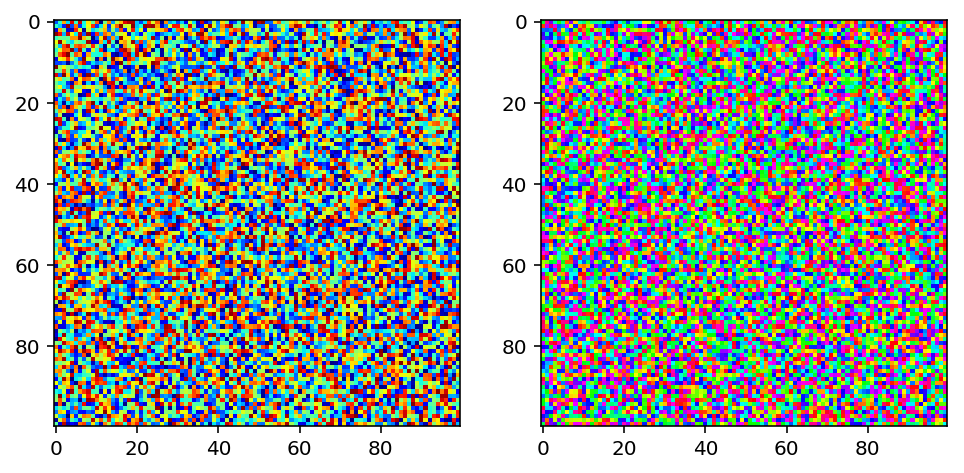

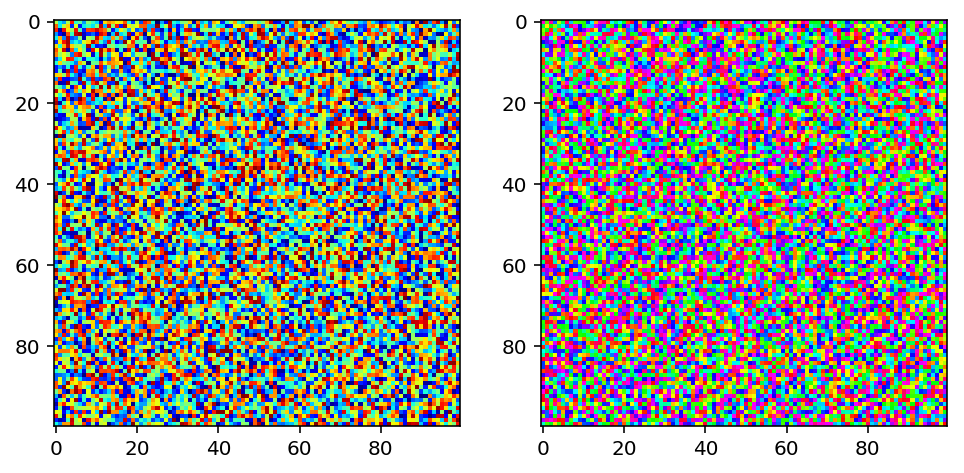

In [31]:
#fig 3, ud3, anim3 are all associated with Update_RD
#fig 4, ud4, anim4 are all associated with Update_RD2

fig3, ax3 = plt.subplots(1,2,figsize=(8,5))  # set up a figure with two panels
fig4, ax4 = plt.subplots(1,2,figsize=(8,5))

ud3 = Update_RD(fig3,ax3, alpha=5.0,beta=9.0,Du=2,Dv=22,\
                 n=100,dt=0.008,dx=1,rdtype='Br',nsteps=200)

ud4 = Update_RD2(fig4,ax4, alpha=5.0,beta=9.0,Du=2,Dv=22,\
                 n=100,dt=0.008,dx=1,rdtype='Br',nsteps=200)
            
anim3 = animation.FuncAnimation(fig3, ud3, frames=np.arange(50), init_func=ud3.init,
                     interval=100, blit=True)
anim4 = animation.FuncAnimation(fig4, ud4, frames=np.arange(50), init_func=ud4.init,
                     interval=100, blit=True)


##### Brusselator model using original Laplacian method and Update_RD

In [28]:
# dt = 0.008
HTML(anim3.to_html5_video())

##### Brusselator model using the new Laplacian method and Update_RD2

In [29]:
# dt = 0.008
HTML(anim4.to_html5_video())

### Problem 4

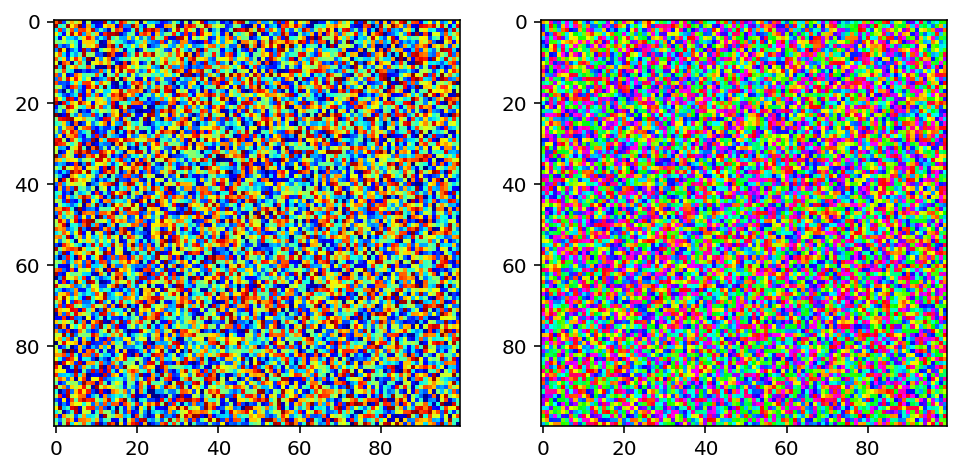

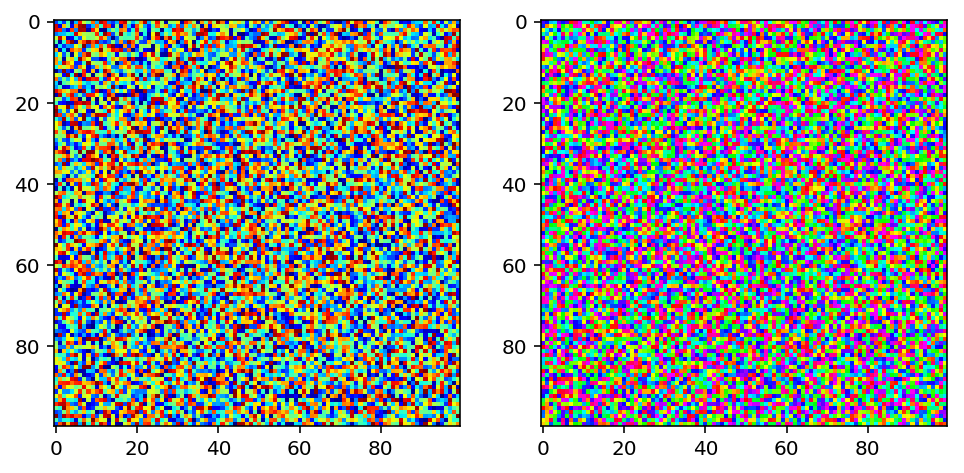

In [113]:
fig5, ax5 = plt.subplots(1,2,figsize=(8,5))  # set up a figure with two panels
fig6, ax6 = plt.subplots(1,2,figsize=(8,5))  # set up a figure with two panels

ud5 = Update_RD2(fig5,ax5, alpha=5.0,beta=9.0,Du=2,Dv=22,\
                 n=100,dt=0.008,dx=1,rdtype='Br2',nsteps=200)
ud6 = Update_RD2(fig6,ax6, alpha=5.0,beta=9.0,Du=2,Dv=17,\
                 n=100,dt=0.001,dx=1,rdtype='GS2',nsteps=200)  

anim5 = animation.FuncAnimation(fig5, ud5, frames=np.arange(50), init_func=ud5.init,
                     interval=100, blit=True)
anim6 = animation.FuncAnimation(fig6, ud6, frames=np.arange(50), init_func=ud6.init,
                     interval=100, blit=True)


In [106]:
HTML(anim5.to_html5_video())

In [114]:
HTML(anim6.to_html5_video())